In [1]:
from MazeEnvironment import MazeEnv
from FeatureExtractor import FeatureExtractor
from stable_baselines3 import PPO
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def evaluate(env, model, num_trials, title):
    stats = {
        'goals': 0,
        'walls': 0,
        'waits': 0
    }
    
    for i in range(1, num_trials + 1):
        s, _ = env.reset()
        while True:
            a, _ = model.predict(s)
            
            s, r, terminated, truncated, info = env.step(a)
            
            if terminated or truncated:
                sr_info = info['step_rewards']
                
                if sr_info['goal'] > 0:
                    stats['goals'] += 1
                elif sr_info['wall'] < 0:
                    stats['walls'] += 1
                else:
                    stats['waits'] += 1
                    
                break
    
        print(f"\r{i}/{num_trials} ({100*i/num_trials:.2f}%)", end='')
    
    print()
    print(f"Completion %: {100*stats['goals']/num_trials:.2f}%")
    print(f"Wall Death %: {100*stats['walls']/num_trials:.2f}%")
    print(f"Wait Death %: {100*stats['waits']/num_trials:.2f}%")
    
    scores = list(stats.values())
    labels = ['Reached Goal', 'Hit Wall', 'Time Out']
    
    plt.title(title)
    plt.pie(scores, labels = labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()

In [3]:
load_dir = "Results/PPO/v1"

path = f'{load_dir}/model'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = PPO.load(path, env = None, device = device)

config_load_path = f"{load_dir}/CONFIG.txt"
with open(config_load_path, 'r') as f:
    CONFIG = json.load(f)

In [4]:
maze_img_path = 'Data/maze_imgs.npy'
maze_arr_path = 'Data/mazes.npy'

maze_imgs = np.load(maze_img_path)
maze_arrs = np.load(maze_arr_path)

split_ratio = CONFIG['train_test_split']

train_maze_imgs = maze_imgs[:int(split_ratio*len(maze_imgs))]
train_maze_arrs = maze_arrs[:int(split_ratio*len(maze_arrs))]

test_maze_imgs = maze_imgs[int(split_ratio*len(maze_imgs)):]
test_maze_arrs = maze_arrs[int(split_ratio*len(maze_imgs)):]

print(f"{len(maze_imgs)} mazes total")
print(f"{len(train_maze_imgs)} training mazes")
print(f"{len(test_maze_imgs)} testing mazes")

3477 mazes total
3303 training mazes
174 testing mazes


In [5]:
do_dfs = CONFIG['training_env']['do_dfs']
base_seed = CONFIG['training_env']['seed']

if do_dfs: env_params = CONFIG['training_env']['env_params_with_dfs']
else: env_params = CONFIG['training_env']['env_params_no_dfs']

test_env = MazeEnv(test_maze_imgs, test_maze_arrs, base_seed, **env_params)
train_env = MazeEnv(train_maze_imgs, train_maze_arrs, base_seed, **env_params)
sample_env = MazeEnv(train_maze_imgs[1:2], train_maze_arrs[1:2], base_seed, **env_params)

In [6]:
policy_kwargs = dict(
    features_extractor_class=FeatureExtractor,
    features_extractor_kwargs={
        'debug': False,
        'input_shape': maze_imgs[0].shape,
    }
)
model = PPO("MultiInputPolicy",env=sample_env, policy_kwargs=policy_kwargs, n_steps = 2112, verbose = 1)
model.set_parameters(path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


100/100 (100.00%)
Completion %: 96.00%
Wall Death %: 4.00%
Wait Death %: 0.00%


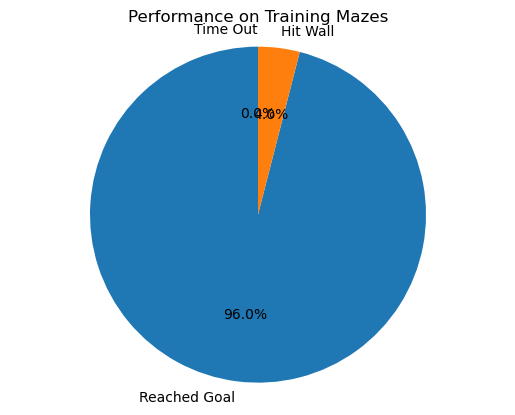

In [7]:
evaluate(train_env, model, 
         num_trials = 100, 
         title = "Performance on Training Mazes")

100/100 (100.00%)
Completion %: 94.00%
Wall Death %: 5.00%
Wait Death %: 1.00%


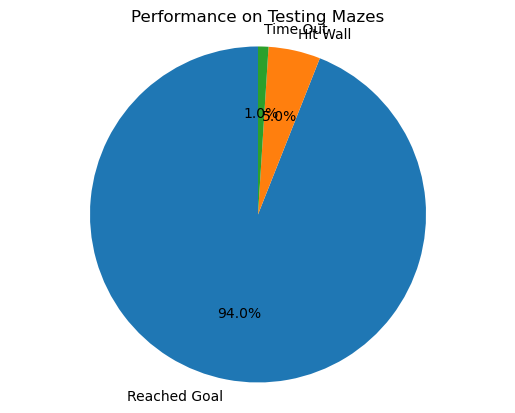

In [9]:
evaluate(test_env, model, 
         num_trials = 100, 
         title = "Performance on Testing Mazes")